In [1]:
import numpy  as np
import matplotlib.pyplot as plt

from scipy import misc

from utils import *

from hcipy import *

%load_ext autoreload
%autoreload 2

## Telescope Setup
Starting with the Magellan pupil (scaled to 3.048 m) till we get a description of the Shane pupil 

In [2]:
pupil_diameter = 3.048 # (meter)
collecting_area = np.pi * (3.048**2 - 0.9779**2)

f_number = 13 # effective focal ratio
effective_focal_length = pupil_diameter * f_number # (meter)

filter_name = 'V'
wavelength = filters[filter_name]['lambda_eff'] * 1e-6 # (meter)

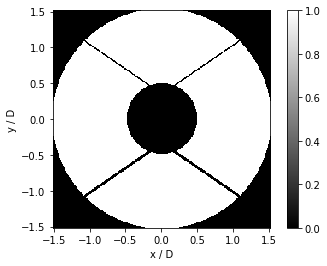

In [3]:
# Generating the pupil grid
grid_size = 256

pupil_grid = make_pupil_grid(grid_size, diameter=pupil_diameter)

# Adjust spiders to represent Shane pupil
telescope_pupil_generator = make_lick_aperture()
telescope_pupil = telescope_pupil_generator(pupil_grid)

im = imshow_field(telescope_pupil, cmap='gray', )
plt.colorbar()
plt.xlabel('x / D')
plt.ylabel('y / D')
plt.show()

## Setting Up the Atmosphere
seeing estimated from the following source: 
https://mthamilton.ucolick.org/techdocs/MH_weather/obstats/avg_seeing.html

In [4]:
seeing = 1.75
outer_scale = 40 # (meter) --> GUESS, NEEDS REFINING
velocity = 20 # (m/s) --> GUESS, NEEDS REFINING

fried_parameter = seeing_to_fried_parameter(seeing, wavelength)
                                
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, wavelength)
tau0 = 0.314 * fried_parameter/velocity

print('r0   = {0:.1f}cm'.format(fried_parameter * 100))
print('L0   = {0:.1f}m'.format(outer_scale))
print('tau0 = {0:.1f}ms'.format(tau0 * 1000))
print('v    = {0:.1f}m/s'.format(velocity))


r0   = 6.3cm
L0   = 40.0m
tau0 = 1.0ms
v    = 20.0m/s


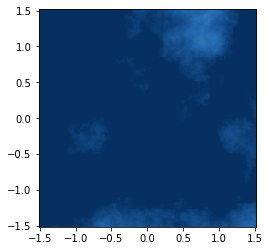

In [5]:
# Generating phase screen
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

phase_screen_phase = layer.phase_for(wavelength) # (radian)
phase_screen_opd = phase_screen_phase * (wavelength / (2 * np.pi)) * 1e6

imshow_field(phase_screen_opd, vmin=-2*np.pi, vmax=2*np.pi, cmap='RdBu')


In [6]:
# Propagating to focal plane

nairy = 100

focal_grid = make_focal_grid(q=4, 
                             num_airy=nairy,
                             pupil_diameter=pupil_diameter,
                             focal_length = effective_focal_length,
                             reference_wavelength=wavelength)
prop = FraunhoferPropagator(pupil_grid, focal_grid, 
                            focal_length=effective_focal_length)


## Add a Primary and Companion

In [7]:
# Primary parameters
mag = 5 #Vega magnitude in the band of interest
stokes_vector= [1.,0.,0.,0.] #I, Q, U, V

# Companion parameters
contrast = 0.9
stokes_ps = [1.,0.3,0.,0.] #I, Q, U, V
angular_separation= 10 # (Lambda/D)

# Exposure time & total number of exposures
exposure_total = 100
exposure_time = 0.01 # (seconds)

### Simulating Image Data

In [8]:
pupil_wavefront = Wavefront(telescope_pupil, wavelength,input_stokes_vector=stokes_vector)
pupil_wavefront.total_power = number_of_photons(mag,filter_name,collecting_area,) # (photons/s)

wf_planet = Wavefront(telescope_pupil*np.exp(4j*np.pi*pupil_grid.x*angular_separation/pupil_diameter),
                      wavelength,
                      input_stokes_vector=stokes_ps)
wf_planet.total_power = contrast * number_of_photons(mag,filter_name,collecting_area,) # (photons/s)

detector_o = NoisyDetector(focal_grid, dark_current_rate=0, read_noise=0, flat_field=0, include_photon_noise=True)
detector_e = NoisyDetector(focal_grid, dark_current_rate=0, read_noise=0, flat_field=0, include_photon_noise=True)

ims_o = []
ims_e = []
HWP_p = []

layer.t = exposure_time

#Wollaston Prism
wollaston = LinearPolarizingBeamSplitter(0)

#Half-wave Plate
HWP_positions = [0., 45., 22.5, 67.5] # degrees

for i in range(exposure_total):
    layer.t+=exposure_time
    angle = HWP_positions[i%len(HWP_positions)]
    HWP = HalfWavePlate(angle)

    star_o, star_e = wollaston(prop(HWP.forward(layer(pupil_wavefront))))
    planet_o, planet_e = wollaston(prop(HWP.forward(layer(wf_planet))))

    detector_o.integrate(star_o,exposure_time)
    detector_o.integrate(planet_o,exposure_time)
    detector_e.integrate(star_e,exposure_time)
    detector_e.integrate(planet_e,exposure_time)

    im_o = detector_o.read_out()
    im_e = detector_e.read_out()
    
    ims_o.append(im_o)
    ims_e.append(im_e)
    
    HWP_p.append(angle)

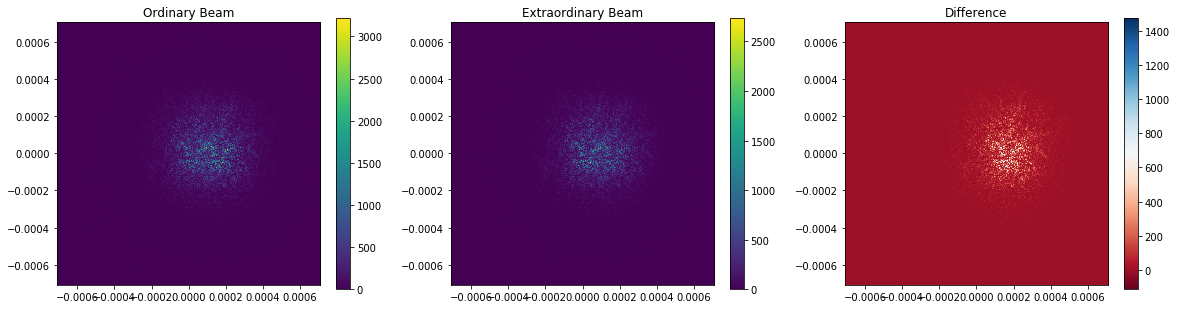

In [9]:
fig,axes = plt.subplots(1,3,figsize=(20,5))

im0 = imshow_field((im_o),ax=axes[0])
im1=imshow_field((im_e),ax=axes[1])
im2=imshow_field((im_o-im_e),ax=axes[2],cmap='RdBu')

axes[0].set_title("Ordinary Beam")
axes[1].set_title("Extraordinary Beam")
axes[2].set_title("Difference")

plt.colorbar(im0, ax=axes[0])
plt.colorbar(im1, ax=axes[1])
plt.colorbar(im2, ax=axes[2])



### Taking FTs to Process Simulated Data

In [10]:
from scipy.ndimage import gaussian_filter

def center_image(img, gsigma, cpix):
#   img: image array
#   gsigma: standard deviation for Gaussian kernel
#   cpix: number of pixels in output image 
    im_o_g = gaussian_filter(img, sigma=gsigma)
    maximum = np.where(im_o_g == np.max(im_o_g))
    
    y1 = int(maximum[0][0] - (cpix/2))
    y2 = int(maximum[0][0] + (cpix/2))
    
    x1 = int(maximum[1][0] - (cpix/2))
    x2 = int(maximum[1][0] + (cpix/2))
    
    center_image = img[y1:y2, x1:x2]

    return(center_image)

In [11]:
                        # change: npix from "np.prod(im_o.shape)" --to--> int(np.sqrt(np.prod(im_o.shape)))
                        # reasoning: want # of pixels on one axis, not the square product of # of pixels
npix = int(np.sqrt(np.prod(im_o.shape)))
bpix = npix - int(0.05*npix)
ipix = 600

im_o_fts = []
im_e_fts = []


for i in range(len(ims_o)):
    im_o = ims_o[i]
    im_e = ims_e[i]
    
    im_o_ft = im_o.copy().reshape([npix,npix])
    im_e_ft = im_e.copy().reshape([npix,npix])
    
#   background subtraction
    im_o_ft_b = im_o_ft.copy()
    im_e_ft_b = im_e_ft.copy()
    
    im_o_ft_b -= np.median(im_o_ft[(bpix):,(bpix):])
    im_e_ft_b -= np.median(im_e_ft[(bpix):,(bpix):])
    
#   image centering    
    im_o_c = center_image(im_o_ft_b, 50, ipix)
    im_e_c = center_image(im_e_ft_b, 50, ipix)

#   supergaussian window
    from utils import supergauss_hw
    
    sg = supergauss_hw(100, 4, ipix)
    
#   fourier transforms   
    FT_o = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(im_o_c * sg)))
    FT_e = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(im_e_c * sg)))

    im_o_fts.append(FT_o/FT_o[int(npix/2),int(npix/2)])
    im_e_fts.append(FT_e/FT_e[int(npix/2),int(npix/2)])

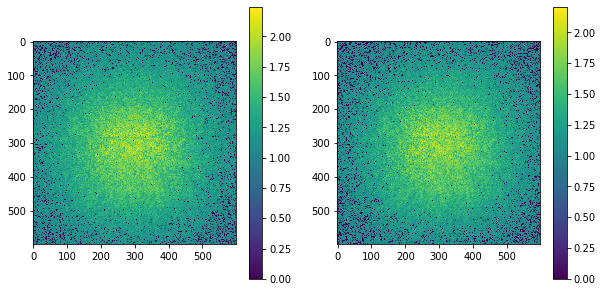

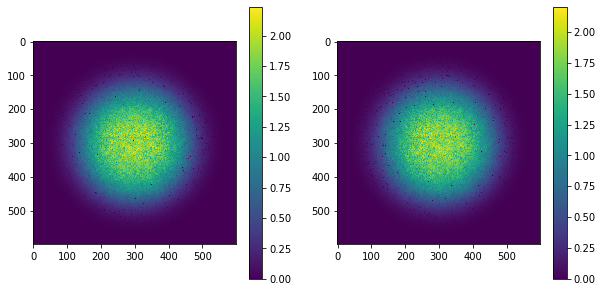

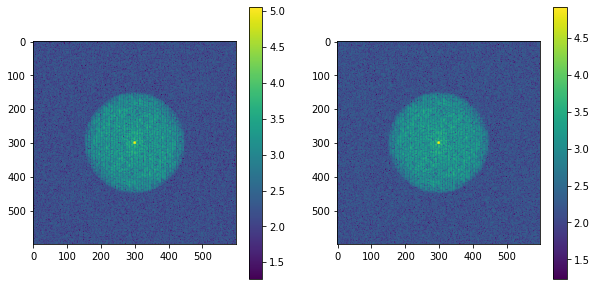

In [12]:
# Plots
# images
f = plt.figure(figsize = (10,5))
f.add_subplot(121)
plt.imshow(np.abs(im_o_c)**0.1)
plt.colorbar()
f.add_subplot(122)
plt.imshow(np.abs(im_e_c)**0.1)  
plt.colorbar()
plt.show()


# supergaussian applied
f = plt.figure(figsize = (10,5))
f.add_subplot(121)
plt.imshow(np.abs(im_o_c * sg)**0.1) 
plt.colorbar()
f.add_subplot(122)
plt.imshow(np.abs(im_e_c * sg)**0.1)
plt.colorbar()
plt.show()

# FT 
f = plt.figure(figsize = (10,5))
f.add_subplot(121)
plt.imshow(np.abs(FT_o)**0.1) 
plt.colorbar()
f.add_subplot(122)
plt.imshow(np.abs(FT_e)**0.1)
plt.colorbar()
plt.show()

## Generating R<sub>U</sub> and R<sub>Q</sub>


In [13]:
def R_U(f_L, f_R, N_e, theta, h):
    #f_L: left side FTs (numpy array of images)
    #f_R: right side FTs (numpy array of images)
    #rho_L: phase slope for left side
    #rho_R: phase slope for right side
    #fs: spatial frequencies that go with FTs
    #N_e: avg number of photons in a single frame
    #theta: HWP angle (measured in deg)

    thetas = np.ones(f_L.shape)
    for x in range(len(thetas)):
        thetas[x] = thetas[x]*theta[x]
    num = np.mean((f_L - f_R) * (f_L + f_R).conj() * np.sin(h*np.radians(thetas)),axis=0)
    den = np.mean((f_L + f_R) * (f_L + f_R).conj() ,axis=0) - 1.0/N_e

    R_U = 1 + num/den
    return(R_U)
    
def R_Q(f_L,f_R,N_e,theta,h):
    thetas = np.ones(f_L.shape)
    for x in range(len(thetas)):
        thetas[x] = thetas[x]*theta[x]
    num=np.mean((f_L - f_R) * (f_L + f_R).conj() * np.cos(h*np.radians(thetas)),axis=0)
    den=np.mean((f_L + f_R) * (f_L + f_R).conj(),axis=0) - 1.0/N_e
    
    R_Q = 1 + num/den
    return(R_Q)



### R<sub>U</sub> & R<sub>Q</sub> Parameters

In [14]:
#for now assume rho_L and rho_R are 0
rho_L = 0
rho_R = 0 
N_e = np.mean([ims_o , ims_e])
harmonic = 4.0
hwps = np.array(HWP_p)

Ru = R_U(np.array(im_o_fts), np.array(im_e_fts), N_e , hwps , harmonic)
Rq = R_Q(np.array(im_o_fts), np.array(im_e_fts), N_e , hwps , harmonic)


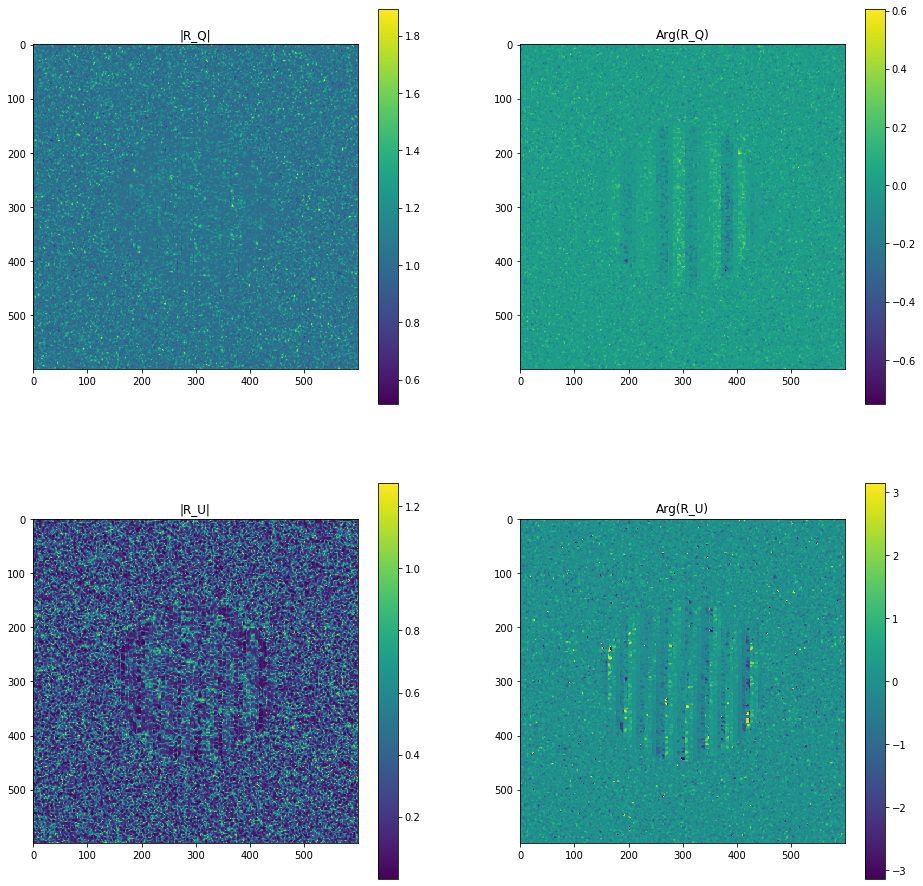

In [15]:
# Plotting Ru & Rq phase, amplitude

f = plt.figure(figsize=(16,16))
f.add_subplot(221)
plt.imshow(np.abs(Rq)) #Rq amplitude
plt.title('|R_Q|')
plt.colorbar()

f.add_subplot(222)
plt.imshow(np.angle(Rq)) #Rq phase
plt.title('Arg(R_Q)')
plt.colorbar()

f.add_subplot(223)
plt.imshow(np.abs(Ru)) #Ru amplitude
plt.title('|R_U|')
plt.colorbar()

f.add_subplot(224)
plt.imshow(np.angle(Ru)) #Ru phase
plt.title('Arg(R_U)') 
plt.colorbar()
plt.show()


## Determining Q, U, and Total Polarized Intensity
Taking Inverse FTs

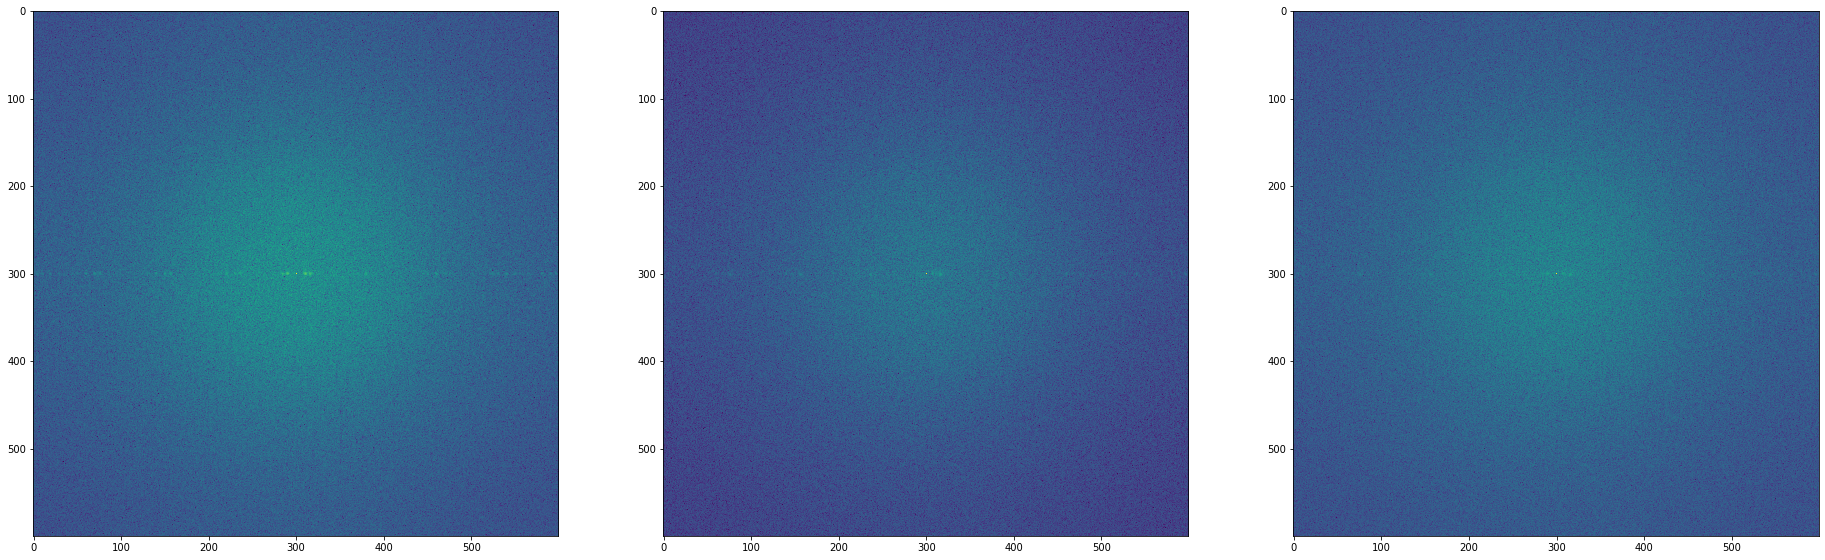

In [16]:
IFT_Q = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(Rq - 1.0)))
IFT_U = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(Ru - 1.0)))

PI = IFT_Q + IFT_U

f = plt.figure(figsize=(32,20))
f.add_subplot(131)
plt.imshow(np.abs(IFT_Q) ** 0.1)
f.add_subplot(132)
plt.imshow(np.abs(IFT_U)** 0.1)
f.add_subplot(133)
plt.imshow(np.abs(PI)** 0.1 )
plt.show()

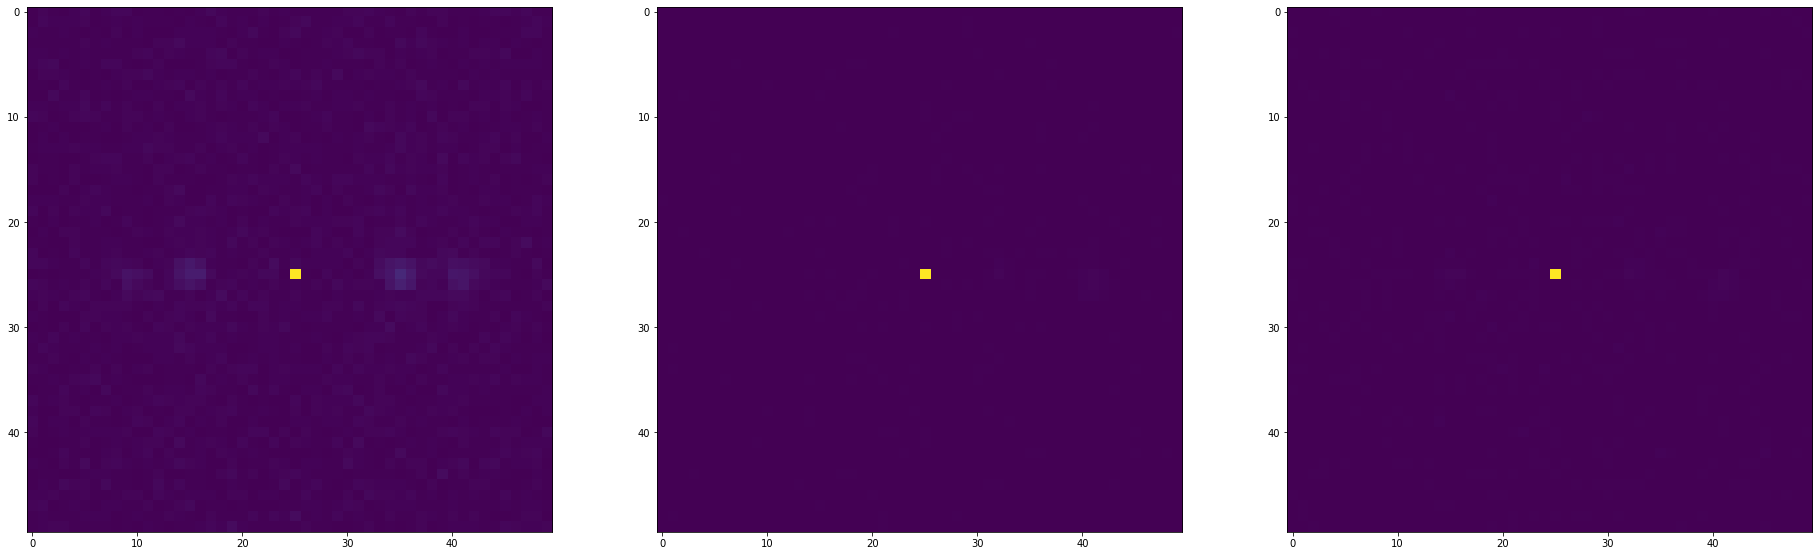

In [17]:
# plotting innermost lambda/D 
IFT_Q1 = []
IFT_U1 = []

IFT_Q1 = IFT_Q[275:325, 275:325]
IFT_U1 = IFT_U[275:325, 275:325]
PI1 = IFT_Q1 + IFT_U1

f = plt.figure(figsize=(32,20))

f.add_subplot(131)
plt.imshow(np.abs(IFT_Q1))
f.add_subplot(132)
plt.imshow(np.abs(IFT_U1))
f.add_subplot(133)
plt.imshow(np.abs(PI1))
plt.show()

## Generating DSP Contrast Curve

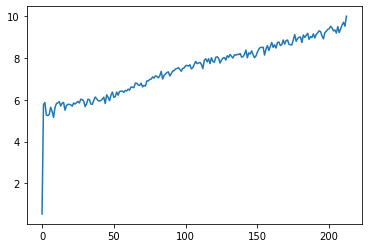

In [18]:
from radial_profile import radial_data

rad_PI = radial_data(np.abs(PI),annulus_width=2)
plt.plot(range(len(rad_PI.std)),-2.5*np.log10(rad_PI.max))
plt.show()